![](https://www.gstatic.com/devrel-devsite/v2355ed73ae6b243a36832e70498f2cd0b3f352ff30481ebdfdc56826b566bf8a/tensorflow/images/lockup.svg)

До сегодняшнего дня мы собирали различные довольно простые модели в высокоуровневом API для [tensorflow](https://www.tensorflow.org/) под названием Keras. Сегодня, наконец, пришло время поиграться с голым ~~королём~~ функционалом библиотеки и посмотреть, как в нём собираются и обучаются самые простые модели. 

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
tf.__version__  # ОУУУУ ЩИИИИТ, ВТОРАЯ ВЕРСИЯ!!! АААААААААААА

'2.2.0'

# 0. Tensoflow teaser

Давайте реализуем на `numpy` и на `tensorflow` функцию для поиска суммы квадратов первых $N$ чисел и посмотрим насколько быстро эти функции работают.

In [ ]:
def np_sum_squares(N):
    return np.sum(np.arange(N)**2)

In [ ]:
%%timeit
N = 10**8
np_sum_squares(N)

Tensorflow из-за того, что мы сначала задаём структуру вычислений, а после осуществляем их. Работает медленнее, чем numpy.

In [ ]:
def tf_sum_squares(N):
    # задаем данные, которые мы не хотим менять
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [ ]:
%%timeit
N = 10**8
tf_sum_squares(N)

Более того, когда вы уже задали свой граф вычислений и убедились, что всё работает, можно вызвать декоратор `tf.function`. [Он сделает работу заданного графа](https://www.tensorflow.org/tutorials/customization/performance) более оптимальной и ещё ускорит код. 

In [ ]:
@tf.function
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [ ]:
%%timeit
N = 10**8
tf_sum_squares(N)

Если сравнивать время, то мы видим значительный прогресс в скорости вычислений даже для простой задачи. Данный прирост будет значительно большим для сложных и тяжелых по памяти рассчетов.

# 1. Тензоры и базовые операции над ними

Основной объект в tensorflow - это **тензор.** Или многомерный массив чисел. Чтобы не нужно было учить кучу новых команд, tensorflow косплеит numpy. 

```
    np.zeros -> tf.zeros
    np.sin -> tf.sin
    np.mean -> tf.reduce_mean
    np.arange -> tf.range
    np.cumsum -> tf.cumsum
```

Правда говоря, не совсем косплеит. Но чаще всего оказываетс довольно близок.

In [ ]:
# можно задать тензор из нулей
tf.zeros([3, 4])

In [ ]:
# или из единиц, но уже более сложной размерности
tf.ones([3, 4, 2])

In [ ]:
# можно сгенерировать тензор из нормального распределения
tf.random.normal([2,2])

In [ ]:
# можно просто сделать залифку тензора какими-то числами
tf.fill([2, 2], 0.5)

In [ ]:
# можно создать матрицу в numpy
x = np.array([[1, 2, 3, 4],
              [4, 3, 2, 1]])
x

In [ ]:
# а потом перевести её в тензор
# tensorflow, когда сталкивается с разными типами данных в тензоре, он пытается их привести к одному
# надо следить за этим
tf.convert_to_tensor(x, tf.float32) 

In [ ]:
# или можно просто сразу создать тензор 
tf.constant([[1,  2,  3,  4],
             [5,  6,  7,  8],
             [9, 10, 11, 12]])

In [ ]:
# наверное, стоит уточнить тип данных в тензоре
x = tf.constant([[1,  2,  3,  4],
                 [5,  6,  7,  8],
                 [9, 10, 11, 12]], dtype=tf.float32)

Все срезы, операции, размерности работают как в numpy.

In [ ]:
x.dtype

In [ ]:
x.shape

In [ ]:
x[0]

In [ ]:
x[:,1]

In [ ]:
x + 10

In [ ]:
x[x > 3]

In [ ]:
y = tf.constant([[12, 11, 10, 9],
                  [8, 7, 6, 5],
                  [4, 3, 2, 1]], dtype=tf.float32)

In [ ]:
x + y

In [ ]:
x**y

In [ ]:
tf.math.exp(x)

In [ ]:
# Когда надоело работать с тензором, можно вернуться назад в numpy формат
x.numpy() 

In [ ]:
# тип у тензоров может быть разный, но всегда один
tf.constant("hello world")

### Задание 1:

Попробуйте реализовать на tensorflow сигмоиду. 

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

In [ ]:
# делаем конвертацию в float
x = tf.linspace(-1.,1.,10)
def sigmoid(x):
    return 1/(1+tf.exp(-x))

In [ ]:
sigmoid(x)

### Задание 2:

Попробуйте реализовать на tensorflow среднюю квадратичную ошибку. 

$$ 
MSE(\hat y, y) = \sum_{i=1}^n (\hat y - y)^2
$$

In [ ]:
y = tf.linspace(-1.,1.,10)
y_pred = tf.linspace(-10.,10.,10)
mse = tf.reduce_sum(tf.pow((y-y_pred), 2))

In [ ]:
mse

------------------------------------------

# 2. Производные да градиенты

Тензорфлоу может вычислять производные и градиенты автоматически. Для этого используется [`GradientTape.`](https://www.tensorflow.org/tutorials/customization/autodiff)

Он проходит по всем операциям, которые фигурируют в графе, и применяет к ним chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

Мы можем посчитать производную по любому тензору, участвующему в вычислениях.

In [ ]:
x = tf.constant([0.3, 1])

# опция persistent=True позволяет искать производную много раз, а не один
with tf.GradientTape(persistent=True) as t:
    # переменная, по которой считаем производную
    t.watch(x)
    y = tf.reduce_sum(x)
    z = y**2

In [ ]:
t.gradient(z, x)

In [ ]:
t.gradient(z, y)

Нарисуем функцию и её производную на картинке :) 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

x = tf.linspace(-3., 3., 100)

with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = x**2

dy_dx = t.gradient(y, x)

plt.plot(x, y, label="$x^2$")
plt.plot(x, dy_dx, label=r"$\frac{dx^2}{dx}$")
plt.legend();

### Задание 3:

Реализуйте расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`

In [ ]:
w = tf.constant([[5,10], [1,2]], dtype=tf.float32)

with tf.GradientTape(persistent=True) as t:
    # переменная, по которой считаем производную
    t.watch(w)
    f = tf.reduce_prod(tf.math.log(tf.math.log(w+7)))

In [ ]:
df_dw = t.gradient(f,w)

# 3. Переменные

Следущий важный объект в tensorflow это **переменная.** Она представляет из себя некоторый буфер в памяти, который содержит текущие тензоры. 

* Переменную можно вставить в любое место графа 
* Переменные можно использовать, чтобы описать какую-то трансформацию
* В процессе расчётов их можно изменять
* Обычно их исползуют для описания параметров модели

In [ ]:
w = tf.Variable(initial_value=0.5)
w

In [ ]:
x = np.array([1,2,3], dtype=float)
x

In [ ]:
x*w

Более того, переменные хороши тем, что Tensorflow сразу же следит за ними при вычислении производных. Ему не надо указывать с помощью команды `watch`, за каким тензором нужно приглядывать. 

### Задание 4:

Реализуйте расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`. Отличие от предыдущей задачки такое: надо задать $w$ не как тензор, а как переменную. 

In [ ]:
w = tf.Variable(initial_value=[[5.,10], [1,2]])

# автоматически следим за variable
# не нужно писать watch
with tf.GradientTape() as t:
    f = tf.reduce_prod(tf.math.log(tf.math.log(w+7)))
df_dw = t.gradient(f,w)

In [ ]:
df_dw

------------------------------------------

# 4. Оптимизация

Итак, tf умеет искать производные, осталось научиться применять его для оптимизации. 

Попробуем решить глупую задачку по конвертации градусов по цельсию в градусы по фаренгейту. По данным будем пытаться восстановить формулу: 

$$ f = c \times 1.8 + 32 $$

In [ ]:
celsius    = np.array([-40, -10,  0,  8, 15, 22,  38],  dtype='float32')
fahrenheit = np.array([-40,  14, 32, 46, 59, 72, 100],  dtype='float32')

for i,c in enumerate(celsius):
    print("{} degrees Celsius = {} degrees Fahrenheit".format(c, fahrenheit[i]))

In [ ]:
# параметры модели 
a = tf.Variable(tf.random.normal([1]), name='bias')
b = tf.Variable(tf.random.normal([1]), name='k')

a.numpy(), b.numpy()

In [ ]:
# Наша модель
# лин регрессию не задали через tf, так как переменные уже заданы через tf
def linear_regression(x):
    return a + b*x

# Ошибка для модели
def mean_square(y_pred, y_true):
    return tf.reduce_mean((y_pred-y_true)**2)

In [ ]:
linear_regression(celsius).numpy()

In [ ]:
mean_square(linear_regression(celsius), fahrenheit).numpy()

In [ ]:
# оптимизатор 
optimizer = tf.optimizers.SGD(learning_rate=0.001)

# процесс оптимизации
def model_train(X, Y):

    # находим loss и пробрасываем градиент
    with tf.GradientTape() as g:
        pred = linear_regression(X)
        loss = mean_square(pred, Y)

    # Вычисляем градиенты
    gradients = g.gradient(loss, [a, b])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [a, b]))
    pass

In [ ]:
a

In [ ]:
model_train(celsius, fahrenheit)

In [ ]:
a

In [ ]:
# Обучение
epochs = 2000 # число эпох 

for i in range(epochs):
    
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    # Каждую сотую итерацию следим за тем, что произошло
    if i%100 == 0:
        y_pred = linear_regression(celsius)
        loss_val = mean_square(y_pred, fahrenheit)
        print("step: %i, loss: %f, a: %f, b: %f" % (i, loss_val, a.numpy(), b.numpy()))

Можно сделать то же самое, но с визуализацией. 

In [ ]:
from IPython.display import clear_output

epochs = 2000 # число эпох 

ass = [a.numpy()[0]] # стартовые точки 
bss = [b.numpy()[0]] 

for i in range(epochs):
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    if i%25 == 0:
        # Пополняем запас точек 
        ass.append(a.numpy()[0])
        bss.append(b.numpy()[0])

        clear_output(True) # чтобы всё на одной картинке рисовалось, а не на милионе
        plt.plot(ass, bss, marker='.')
        plt.scatter(32, 1.8, c='red')
        plt.show()

### Задача 2 из семинара

In [ ]:
class simple_model:
    def __init__(self):
        self.w1 = tf.Variable(tf.random.normal([1]), name='w1')
        self.w2 = tf.Variable(tf.random.normal([1]), name='w2')
        self.optimizer = tf.optimizers.SGD(learning_rate=0.001)
        
    def calc_prediction(self,x):
        pred = tf.constant(1., tf.float32)*self.w1 + self.w2*x
        return tf.maximum(0,pred)
    
    def mean_square(y_pred, y_true):
        return tf.reduce_mean((y_pred-y_true)**2)
    
    def model_train(self, X, Y):

        # находим loss и пробрасываем градиент
        with tf.GradientTape() as g:
            pred = self.calc_prediction(X)
            loss = self.mean_square(pred, Y)

        # Вычисляем градиенты
        gradients = g.gradient(loss, [self.w1, self.w2])

        # Обновляем веса a и b в ходе одной итерации спуска 
        optimizer.apply_gradients(zip(gradients, [self.w1, self.w2]))

In [ ]:
x = np.array([0.,1.], dtype=np.float32)
y = np.array([1.,0.], dtype=np.float32)

In [ ]:
ss_model = simple_model()
ss_model.calc_prediction(x)

In [ ]:
for i in range(100):
    print(f'w1={ss_model.w1.numpy()}, w2={ss_model.w2.numpy()}')
    ss_model.model_train(x,y)

In [ ]:
# с деократором для оптимизации
class simple_model:
    def __init__(self):
        self.w1 = tf.Variable(tf.random.normal([1]), name='w1')
        self.w2 = tf.Variable(tf.random.normal([1]), name='w2')
        self.optimizer = tf.optimizers.SGD(learning_rate=0.001)
        
    def calc_prediction(self,x):
        pred = tf.constant(1., tf.float32)*self.w1 + self.w2*x
        return tf.maximum(0.,pred)
    
    # ставим декоратор перед самой верхнеуровневой функцией
    @tf.function
    def mean_square(y_pred, y_true):
        return tf.reduce_mean((y_pred-y_true)**2)
    
    def model_train(self, X, Y):

        # находим loss и пробрасываем градиент
        with tf.GradientTape() as g:
            pred = self.calc_prediction(X)
            loss = self.mean_square(pred, Y)

        # Вычисляем градиенты
        gradients = g.gradient(loss, [self.w1, self.w2])

        # Обновляем веса a и b в ходе одной итерации спуска 
        optimizer.apply_gradients(zip(gradients, [self.w1, self.w2]))

In [ ]:
x = np.array([0.,1.], dtype=np.float32)
y = np.array([1.,0.], dtype=np.float32)

In [ ]:
ss_model2 = simple_model()
ss_model2.calc_prediction(x)

In [ ]:
for i in range(100):
    print(f'w1={ss_model.w1.numpy()}, w2={ss_model.w2.numpy()}')
    ss_model2.model_train(x,y)

### Задание 5:

Реализуйте для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

процедуру градиентного спуска. Каким получилось минимальное значение? 

In [ ]:
w = tf.Variable(initial_value=[[5.,10.], [1.,2.]])

In [ ]:
func_optimizer = tf.optimizers.Adam(learning_rate=0.001)
for step in range(1000):
    with tf.GradientTape() as t:
        f = tf.reduce_prod(tf.math.log(tf.math.log(w+7)))
    df_dw = t.gradient(f,[w])
    func_optimizer.apply_gradients(zip(df_dw, [w]))
    func = tf.reduce_prod(tf.math.log(tf.math.log(w+7)))
    #print(func.numpy())

In [ ]:
func

------------------------------------------

Можно попробовать поразвлекаться с разными методами оптимизации! 

* На вход модели при обучении мы сейчас подавали нумпаевские вектора. В будущем мы будем смотреть и на разные другие способы скармливать модели данные.

# 5. Нейронка на Tensorflow 

Пришло время страдать. Чтобы пострадать как следует, вы получаете задание --- построить свою первую нейросеть в tensorflow. __Спойлер:__ cильнее вего вы будете страдать от того, что размерности матриц не сходятся. Осторожнее с этим. 

Раньше все учили свою первую нейросеть на [наборе рукопистных цифр MNIST.](http://yann.lecun.com/exdb/mnist/) Теперь это не модно. Если где-то кто-то будет проводить у вас семинар с участием этого датасета, так и скажите ему: __это не модно!__  Хлопать дверью или нет --- на ваше усмотрение. 

На арене туториалов новый король: [Fashion MNIST.](https://www.tensorflow.org/tutorials/keras/classification) По ссылке лежит туториал с строительством нейросетки на этом наборе, но с участием Keras. Мы пока что обойдёмся без него.

In [125]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [126]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [127]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Нарисуем несколько рандомных картинок из тренировочной выборки. 

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline

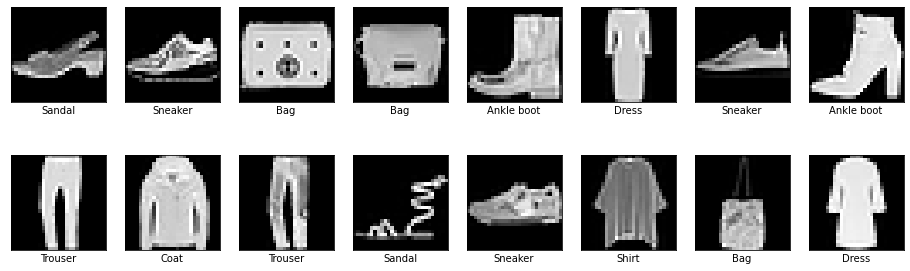

In [129]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X_train[random_index, :], cmap = 'gray')
        ax.set_xlabel(class_names[y_train[random_index]])
plt.show()

Каждая картинка это матрица из чисел. Если число большое - пиксель яркий. Если маленькое - тёмный. Яркость измеряется по шкале от $0$ до $255$.

In [ ]:
X_train[0]

Картинка - матрица. 

In [ ]:
X_train[0].shape

Давайте отнормируем выборку. 

In [130]:
X_train = X_train/255
X_test = X_test/255

Будем прогнозировать тип картинки по её пикселям. Давайте растянем её в вектор из $28 \times 28$ фичей.

In [131]:
X_train = X_train.reshape(X_train.shape[0], 28**2)
X_test = X_test.reshape(X_test.shape[0], 28**2)
X_train.shape

(60000, 784)

Поставим для данных тип, чтобы ничего не поломалось.

In [132]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

У нас в задаче фигурирует $10$ классов. Последним слоем в сетке будет Softmax. Не забудьте сделать OHE, когда будете описывать функцию потерь. 

In [133]:
tf.keras.utils.to_categorical(y_train)

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [134]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Задание 6

Для начала обучим однослойною модель. Задайте её архитектуру и напишите функцию для прогнозирования. 

In [ ]:
num_classes = 10   # число классов
num_features = 784 # число фичей (28*28 пикселей)

# Задайте переменные W и b :) 
# делаем 10 прогнозов, для этого делаем 1 слой из 10 нейронов (то есть 10 моделей)
# bias у нас 1 для нейрона
w = tf.Variable(tf.random.normal([num_features, num_classes]), name='w')
b = tf.Variable(tf.random.normal([num_classes]), name='b')

# прогнозы
def logistic_regression(X):
    return tf.nn.softmax(tf.matmul(X,w)+b)

In [ ]:
p_pred = logistic_regression(X_train[:3])
p_pred

Отлично! Теперь давайте реализуем функцию потерь. Использовать будем logloss. Ещё не забыли как его искать? 

In [ ]:
def logloss(p_pred, y_true):
    # Чтобы не возникло log(0) и бесконечностей
    # все что выше 1 будет превращаться в 1, все что ниже 1e-9 будет превращаться в 1e-9
    p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
    # а теперь считаем logloss
    # axis - по чему мы суммируем
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1)) 

In [ ]:
p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
#tf.reduce_mean(tf.reduce_sum(y_train[:3] * tf.math.log(p_pred), axis=1))

Чтобы избежать проблем с бесконечностями, обычно logloss считают по-другому, с помощью функции tf.nn.softmax_cross_entropy_with_logits. Откуда берутся проблемы в виде бесконечностей в softmax либо посмотрите во второй лекции, либо в Николенко на страницах  133−135.

In [ ]:
p_pred = logistic_regression(X_train)
logloss(p_pred, y_train)

На каждой итерации будем искать accuracy. Напишите функцию, чтобы его искать. 

In [ ]:
tf.cast(tf.equal(tf.argmax([1,2,3]), tf.argmax([10,20,30])), np.float32)

In [ ]:
def accuracy(y_pred, y_true):
    # смотрим, у какой позиции наибольшая вероятность
    # смотрим, совпадают ли позиции 1 в предсказании и в начальном датасете
    # у нас 10 возможных позиций - классов
    correct_prediction = tf.equal(tf.argmax(y_pred,axis=1), tf.argmax(y_true,axis=1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    return tf.reduce_mean(correct_prediction)

In [ ]:
p_pred[0][-3]

In [ ]:
# выдал 1, значит позиции максимальной веротяности совпали
accuracy(p_pred, y_train)

Задаём оптимизатор

In [ ]:
learning_rate = 1e-4
optimizer = tf.optimizers.Adam(learning_rate)

Задаём один шаг обучения

In [ ]:
def model_train(X, Y):

# Считаем градиенты
    with tf.GradientTape() as g:
        p_pred = logistic_regression(X)
        logloss_value = logloss(p_pred, Y)
    gradients = g.gradient(logloss_value,[w,b])
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [w, b]))

In [ ]:
w

In [ ]:
# Работает ли?
model_train(X_train, y_train)

In [ ]:
w

Остался только этап для обучения модели. Напишем функцию, которая будет генерировать из наших данных батчи. Одна эпоха - один проход модели по всем батчам. Один батч - совокупность наблюдений.  В этом может помочь [специальный класс для создания батчей, Dataset.](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [135]:
# создали объект с данными для обучения 
# нарезали датасет на части, состоящие из 1 наблюдения (признаки и целевые перменнные)
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# перемешали данные с окном в 5000 и сделали кучу батчей размера 512 
train_data = train_data.shuffle(5000).batch(512)

Напишем небольшую функцию для визуализации процедуры обучения. 

In [139]:
from IPython import display

def visualize(l1,l2, h1, h2):
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()

Обучаем модель! 

In [136]:
class logistic_regression:
    def __init__(self, num_features, num_classes):
        self.num_features = num_features
        self.num_classes = num_classes
        self.w = tf.Variable(tf.random.normal([self.num_features, self.num_classes]), name='w')
        self.b = tf.Variable(tf.random.normal([self.num_classes]), name='b')
        self.optimizer = tf.optimizers.Adam(0.01)
        
    def logistic_regression(self, X):
        return tf.nn.softmax(tf.matmul(X,self.w)+self.b)
    
    def logloss(self, p_pred, y_true):
        p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
        return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1))
    
    def accuracy(self, y_pred, y_true):
        correct_prediction = tf.equal(tf.argmax(y_pred,axis=1), tf.argmax(y_true,axis=1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        return tf.reduce_mean(correct_prediction)
    
    def model_train(self, X, Y):
        
        with tf.GradientTape() as g:
            p_pred = self.logistic_regression(X)
            logloss_value = self.logloss(p_pred, Y)
        gradients = g.gradient(logloss_value,[self.w,self.b])
        self.optimizer.apply_gradients(zip(gradients, [self.w, self.b]))


In [137]:
num_classes = 10
num_features = 784

lr = logistic_regression(num_features, num_classes)

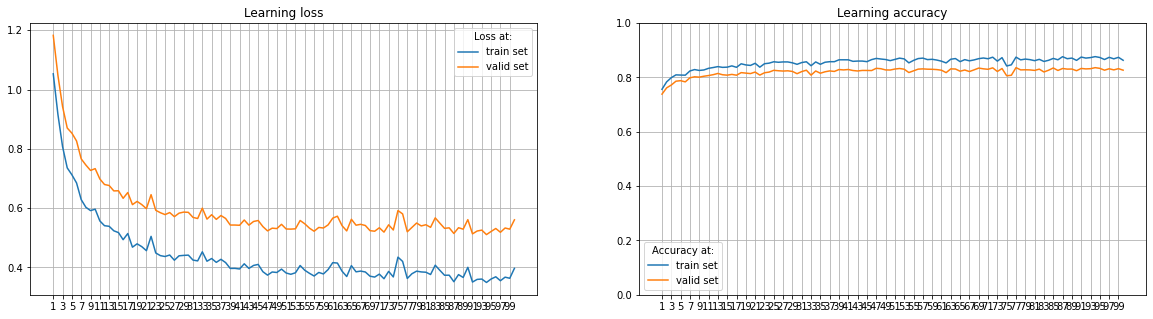

In [140]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        # Делаем шаг градиентного спуска 
        lr.model_train(batch_x, batch_y)
    
    # в конце эпохи считаем метрики
    p_train = lr.logistic_regression(X_train)
    p_test = lr.logistic_regression(X_test)

    loss_train.append(lr.logloss(p_train, y_train))
    loss_test.append(lr.logloss(p_test, y_test))

    acc_train.append(lr.accuracy(p_train, y_train))
    acc_test.append(lr.accuracy(p_test, y_test))

    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

Делать такие визуализации для больших нейронок и большого количества эпох не лучшая идея, но так как мы только учимся и хотим красивых картинок, то мы можем себе это позволить. __Отдельно обратите внимание,__ что TensorFlow очень чуствительна к размерностям. Например, чтобы работала функция `matmul`, нужно подать ей на вход обязательно матрицы. Даже если это матрица размера $1 \times 1$.

## Задание 7

Переделайте свою логистическую регрессию в двухслойную нейросетку. В качестве функции активации возьмите что угодно. Функцию, где будет реализована модель назовите `our_nn`.

In [155]:
class our_nn:
    def __init__(self, num_features, num_classes):
        self.num_features = num_features
        self.num_classes = num_classes
        self.w1 = tf.Variable(tf.random.normal([self.num_features, self.num_classes]), name='w1')
        self.b1 = tf.Variable(tf.random.normal([self.num_classes]), name='b1')
        self.w2 = tf.Variable(tf.random.normal([self.num_classes, self.num_classes]), name='w2')
        self.b2 = tf.Variable(tf.random.normal([self.num_classes]), name='b2')
        self.optimizer = tf.optimizers.Adam(0.01)
        
    def nn(self, X):
        hidden_neurons = tf.nn.relu(tf.matmul(X,self.w1)+self.b1)
        return tf.nn.softmax(tf.matmul(hidden_neurons,self.w2)+self.b2)
    
    def logloss(self, p_pred, y_true):
        p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
        return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1))
    
    def accuracy(self, y_pred, y_true):
        correct_prediction = tf.equal(tf.argmax(y_pred,axis=1), tf.argmax(y_true,axis=1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        return tf.reduce_mean(correct_prediction)
    
    def model_train(self, X, Y):
        
        with tf.GradientTape() as g:
            p_pred = self.nn(X)
            logloss_value = self.logloss(p_pred, Y)
        gradients = g.gradient(logloss_value,[self.w1,self.b1, self.w2,self.b2])
        self.optimizer.apply_gradients(zip(gradients, [self.w1,self.b1, self.w2,self.b2]))

In [156]:
num_classes = 10
num_features = 784

our_nn = our_nn(num_features, num_classes)

Обучаем модель!

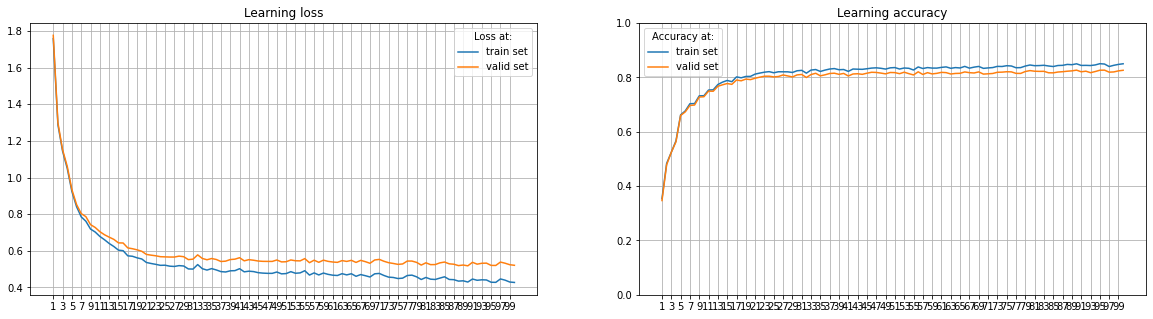

In [157]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        # Делаем шаг градиентного спуска 
        our_nn.model_train(batch_x, batch_y)
    
    # в конце эпохи считаем метрики
    p_train = our_nn.nn(X_train)
    p_test = our_nn.nn(X_test)

    loss_train.append(our_nn.logloss(p_train, y_train))
    loss_test.append(our_nn.logloss(p_test, y_test))

    acc_train.append(our_nn.accuracy(p_train, y_train))
    acc_test.append(our_nn.accuracy(p_test, y_test))

    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

In [145]:
acc_test[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.8437>

# Вместо итога.

__Но... Но... Но... Намного проще собрать это в Keras! Зачем нам страдать?__

Дело в том, что Keras лишь надстройка над tensorflow. По факту все слои, написанные для Keras - это замаскированный tensorflow. Более того, даже сетку, написанную на Keras можно обучать таким вот незатейливым циклом, как у нас. Иногда так намного проще проверять свои идеи. 

* Например, в прошлый раз мы с вами пытались мень скорость обучения сетки с помощью колбэков прямо в процессе обучения. Это было довольно неприятно и код был неочевидным. Если описывать процедуру обучения в виде цикла, работать становится проще.  В Tensorflow проще делать довольно много разных вещей, а также проще реализовывать и проверять какие-то свои идеи. 
* В том числе на Tensorflow можно писать новые слои для Keras и встраивать их в свои сетки. Этим мы тоже с вами позанимаемся.

In [ ]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layer
import tensorflow.keras.optimizers as opt
from tensorflow.keras.losses import categorical_crossentropy

model = Sequential()
model.add(layer.Dense(10,activation='softmax',input_shape=(784,)))
model.compile(optimizer='rmsprop', loss=categorical_crossentropy)

# N+1. Как Tensorflow работал раньше 

Больше такой код не надо писать никогда и нигде. Если видите его в туториалах в интернете, сразу закрывайте их. Эти туториалы устарели. Можете попробовать подуть на них (сдуть слой пыли), а дальше попробовать самостоятельно переписать старый код на новый. Это неплохое упражнение :) 

In [ ]:
import tensorflow.compat.v1 as tf  # подгружаем первую версию библиотеки 
tf.disable_v2_behavior()           # отключаем функционал второй 
                                   # теперь код, написанный на версии tf 1.x должен работать 
tf.__version__

Раньше сначала надо было задать структуру вычислений с помощью тензоров. 

In [ ]:
# что происходило в первой версии 
a = tf.constant([1, 2])
b = tf.constant([3, 4])

# мы не видим результат
print(a + b)

Результат на лету было увидеть нельзя. 

In [ ]:
c = a + b
c

Если хотелось результата, надо было запускать вычислительную сессию, которая прогоняла все данные через граф.

In [ ]:
# открываем вычислительную сессию 
with tf.Session() as sess:
    print(sess.run(c))

In [ ]:
# либо можно было открыть глобальную сессию 
sess = tf.InteractiveSession()
c.eval()

In [ ]:
190/50493

Процедура обучения модели выглядела раньше иначе. Кроме переменных в обучении участие принимал ещё один объект, `placeholder`. 

* __placeholder__ — место в графе, которое может принимать входные параметры в граф извне. В эти места мы будем вставлять наши данные

In [ ]:
epochs = 10

# плейсхолдеры для данных 
# "Я обещаю вставить сюда x и y позже"
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

# параметры модели 
a = tf.Variable(tf.zeros([1]), name='bias')
b = tf.Variable(tf.zeros([1]), name='k')

# модель 
y_hat = b*x + a

# функция потерь и метод оптимизации
loss = tf.sqrt(tf.reduce_sum((y - y_hat)**2))
opt = tf.train.AdamOptimizer(learning_rate = 0.1)

# из-за того, что не было динамических вычислений, 
# было проще с градиентами
step = opt.minimize(loss)

# Но зато было сложнее с процедурой обучения, надо было запускать ... сессии
# открываем вычислительную сессию 
with tf.Session() as sess:
    
    # инициализировали все переменные 
    tf.global_variables_initializer().run() 
    
    for i in range(epochs):
        
        # Дорогая сессия, вычисли мне результат функции потерь, пожалуйста! Вот тебе конкретные x и y! 
        cur_loss = sess.run(loss, feed_dict={x:celsius, y:fahrenheit})
        print('Текущие потери:', cur_loss)
        
        # шаг оптимизации 
        sess.run(step, feed_dict={x:celsius, y:fahrenheit})
        
    print('\nКоэффициенты:', a.eval()[0], b.eval()[0])
    print('Прогнозы:', sess.run(y_hat, feed_dict={x:[-40,0,38]}))

## Почиташки

* [Эффективный tensorflow 2.0](https://www.tensorflow.org/guide/effective_tf2)
* [Простые примеры кода на tensorflow 2.0](https://github.com/aymericdamien/TensorFlow-Examples/tree/master/tensorflow_v2)
* [Очень-очень милая презентация про fashion mnist](https://github.com/fbchow/fashion-mnist-tensorflow/blob/master/ml-fashion-mnist-presentation.pdf)


__Немного старья:__

* [Введение в старую версию Tensorflow на Хабре](https://habrahabr.ru/company/ods/blog/324898/)
* [Введение в старый Tensorflow от ШАД,](https://nbviewer.jupyter.org/github/yandexdataschool/Practical_DL/blob/fall18/week02_autodiff/seminar_tensorflow.ipynb) моя тетрадка частично основана на этой тетрадке, хоть сходство на первый взгляд и не заметно. 
* [Неплохая подборка разных тетрадок](https://github.com/Hvass-Labs/TensorFlow-Tutorials) на старом tensorflow